In [75]:
import sys
sys.path.append("/project")

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.utils.data as torchdata

import jax
import jax.numpy as jnp
from flax import linen as nn
from flax import traverse_util
from flax.core.frozen_dict import freeze

from rrmpg.models import GR4J
from sklearn.model_selection import train_test_split

sys.path.append("..")
import model.hydro.gr4j_prod_flax as j_prod
from model.ml.cnn_flax import ConvNet
from model.utils.training import EarlyStopper
from model.utils.evaluation import evaluate, nse
from data.utils import read_dataset_from_file, get_station_list
from data.camels_sampler import CamelsBatchSampler


In [76]:
from tqdm import tqdm

from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax 

In [77]:
data_dir = '/data/camels/aus/'
sub_dir = 'no-scale'
station_id = '917107A' # '105105A'

In [78]:
train_ds, val_ds = read_dataset_from_file(data_dir, sub_dir, 
                                          station_id=station_id)

t_train, X_train, y_train = train_ds.tensors
t_val, X_val, y_val = val_ds.tensors

## Generate Synthetic Streamflow using Calibrated GR4J

In [79]:
# Create model instance
model = GR4J()

# Training data tensors
P_train = X_train[:, 0].detach().numpy()
ET_train = X_train[:, 1].detach().numpy()
Q_train = y_train.flatten().detach().numpy()

# Fit the model
result = model.fit(Q_train, P_train, ET_train)

# Update GR4J parameters
params = {}
param_names = model.get_parameter_names()
for i, param in enumerate(param_names):
    params[param] = result.x[i]

# This line set the model parameters to the ones specified in the dict
model.set_params(params)

In [80]:
X = torch.concat([X_train, X_val])
y = torch.concat([y_train, y_val])


# Training data tensors
P = X[:, 0].detach().numpy()
ET = X[:, 1].detach().numpy()
Q = y.flatten().detach().numpy()

# Synthetic flow
Q_syn = model.simulate(P, ET).flatten()

Plot the synthetic flow data

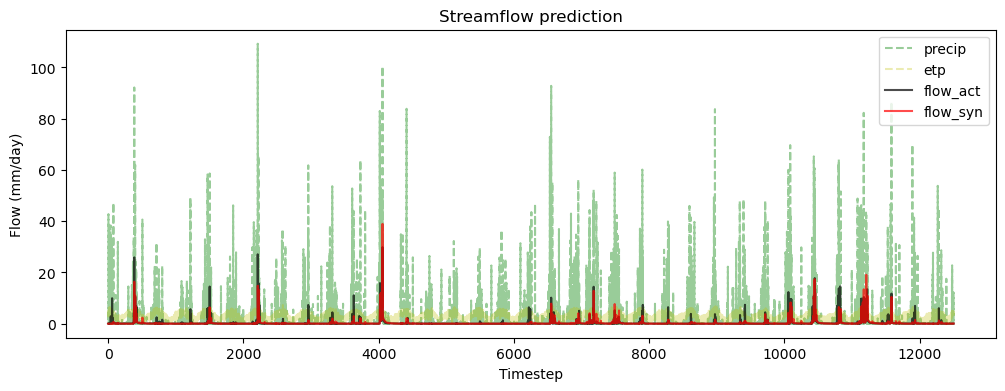

In [81]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(P, 'g--', label='precip', alpha=0.40)
ax.plot(ET, 'y--', label='etp', alpha=0.30)
ax.plot(Q, color='black', label='flow_act', alpha=0.7)
ax.plot(Q_syn, color='red', label='flow_syn', alpha=0.7)

ax.set_xlabel('Timestep')
ax.set_ylabel('Flow (mm/day)')

ax.set_title('Streamflow prediction')
ax.legend()

In [82]:
params

{'x1': 947.8312115189002,
 'x2': -0.08053674965167631,
 'x3': 20.0,
 'x4': 1.1503349404140784}

## Split and create datasets

In [83]:
x1 = params['x1']

scale = 1000.0
x1_init = x1/scale
s_init = 0.0

In [84]:
y = torch.from_numpy(Q_syn.reshape((-1, 1)))
X = torch.nan_to_num(X)

y_mu = y.mean(dim=0)
y_sigma = y.std(dim=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    shuffle=False)

y_train = (y_train - y_mu)/y_sigma
y_test = (y_test - y_mu)/y_sigma

In [85]:
prod_store = j_prod.ProductionStorage(s_init=s_init, 
                                      x1_init=x1_init, 
                                      scale=scale)

params = prod_store.init(rngs={'params': jax.random.PRNGKey(0)}, 
                         x=jnp.ones((1, 5)))

params

FrozenDict({
    params: {
        x1: DeviceArray([0.9478312], dtype=float32),
    },
})

In [86]:
x_out, s_store = prod_store.apply(params, X.detach().numpy())

x_mu = x_out.mean(axis=0)
x_sigma = x_out.std(axis=0)

## Train Hybrid Model

In [87]:
window_size = 7
batch_size = 256
n_epoch = 250

in_channels = 1
n_features = 5
n_filters = (8, 8, 6)
dropout = 0.1

weight_decay = 0.06

lr = 1e-3

In [88]:
class HyGR4J(nn.Module):
    x1_init: float
    s_init: float
    x_mu: np.ndarray
    x_sigma: np.ndarray
    n_filters: tuple=(8, 8, 6)
    dropout_p: float=0.2
    window_size: int=7
    training: bool=True
    scale: float=1000.0

    def setup(self):
        self._prod_store = j_prod.ProductionStorage(x1_init=self.x1_init,
                                                   s_init=self.s_init,
                                                   scale=self.scale)
        self._model = ConvNet(n_filters=self.n_filters,
                              dropout_p=self.dropout_p,
                              training=self.training)
    
    def create_sequence(self, X, q):

        # Create empyty sequences
        Xs, ys = [], []

        # Add sequences to Xs and ys
        for i in range(1, len(X) - self.window_size):
            Xs.append(jnp.concatenate([
                                    X[i: (i + self.window_size)],
                                    q[i - 1:(i + self.window_size) - 1]
                                ], axis=1))

        Xs = jnp.stack(Xs)
        Xs = jnp.expand_dims(Xs, axis=3)

        return Xs

    
    def __call__(self, x, q):
        prod_out, s_store = self._prod_store(x)
        prod_out = (prod_out - self.x_mu)/self.x_sigma
        seq = self.create_sequence(prod_out, q)
        q_out = self._model(seq)
        return q_out, s_store[-window_size-2]
         

In [89]:
# Key Generators
root_key = jax.random.PRNGKey(seed=1)
main_key, params_key, dropout_key = jax.random.split(key=root_key, num=3)

In [90]:
hygr4j = HyGR4J(x1_init=x1_init, s_init=s_init, 
                n_filters=n_filters, dropout_p=dropout,
                x_mu=x_mu, x_sigma=x_sigma, window_size=window_size,
                scale=scale)


In [91]:
train_ds = torchdata.TensorDataset(X_train, y_train)
train_batch_sampler = CamelsBatchSampler(train_ds, batch_size=batch_size, 
                                         window_size=window_size,
                                         drop_last=False)
train_dl = torchdata.DataLoader(train_ds, batch_sampler=train_batch_sampler, 
                                num_workers=2, prefetch_factor=2)




test_ds = torchdata.TensorDataset(X_test, y_test)
test_batch_sampler = CamelsBatchSampler(test_ds, batch_size=batch_size, 
                                       window_size=window_size,
                                       drop_last=False)
test_dl = torchdata.DataLoader(test_ds, batch_sampler=test_batch_sampler,
                              num_workers=2, prefetch_factor=2)

In [92]:
@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')

In [93]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    key: jax.random.KeyArray

def create_train_state(module, params_key, dropout_key, lr):
    """Creates an initial `TrainState`."""
    
    params = module.init({'params': params_key, 'dropout': dropout_key}, 
                     jax.random.normal(main_key, (batch_size, n_features)), 
                     jax.random.normal(main_key, (batch_size, 1)))['params']
    
    tx = optax.adamw(lr, b1=0.89, b2=0.97, weight_decay=weight_decay)

    return TrainState.create(apply_fn=module.apply, 
                             params=params, tx=tx,
                             key=dropout_key,
                             metrics=Metrics.empty())

In [94]:
@jax.jit
def train_step(state, dropout_key, batch, targets):
    """Train for a single step."""
    
    def loss_fn(params):
        preds, s_store = state.apply_fn({'params': params}, batch, targets,
                                rngs={'dropout': dropout_key})
        loss = optax.l2_loss(preds, targets[window_size+1:]).mean()
        return loss
    
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    return state

In [95]:
@jax.jit
def compute_metrics(*, state, dropout_key, batch, targets):
    
    preds, s_store = state.apply_fn({'params': state.params}, batch, targets,
                            rngs={'dropout': dropout_key})
    
    loss = optax.l2_loss(preds, targets[window_size+1:]).mean()
    
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    
    return state, s_store

In [96]:
state = create_train_state(hygr4j, params_key=params_key,
                           dropout_key=dropout_key, lr=lr)

In [97]:
metrics_history = {'train_loss': [],
                   'test_loss': [],
                   'x1': []}

In [98]:
pbar = tqdm(range(1, n_epoch+1))
# Early stopping
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

for epoch in pbar:

    hygr4j.s_init = s_init
    hygr4j.training = True

    # Train step
    for step, (batch, targets) in enumerate(train_dl):

        batch = batch.detach().numpy()
        targets = targets.detach().numpy()

        state = train_step(state, dropout_key, batch, targets)
        state, s_store_train = compute_metrics(state=state, 
                                               dropout_key=dropout_key,
                                               batch=batch, targets=targets)
        hygr4j.s_init = s_store_train/(state.params['_prod_store']['x1']*hygr4j.scale)
    
    for metric, value in state.metrics.compute().items(): # compute metrics
        metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty())

    # Validation step
    test_state = state
    hygr4j.s_init = s_init
    hygr4j.training = False
    for step, (batch, targets) in enumerate(test_dl):
        batch = batch.detach().numpy()
        targets = targets.detach().numpy()
        test_state, s_store_test = compute_metrics(state=test_state, 
                                                   dropout_key=dropout_key,
                                                   batch=batch, targets=targets)
        hygr4j.s_init = s_store_test/(test_state.params['_prod_store']['x1']*hygr4j.scale)

    for metric, value in test_state.metrics.compute().items():
        metrics_history[f'test_{metric}'].append(value)
    
    metrics_history['x1'].append(state.params['_prod_store']['x1'])
    
    pbar.set_description(f"""Epoch {epoch}/{n_epoch} loss: {metrics_history['train_loss'][-1]:.4f} val_loss: {metrics_history['test_loss'][-1]:.4f}""")

    if early_stopper.early_stop(metrics_history['test_loss'][-1]):
        break

Epoch 70/250 loss: 0.1133 val_loss: 0.2367:  28%|██▊       | 69/250 [04:13<11:06,  3.68s/it]


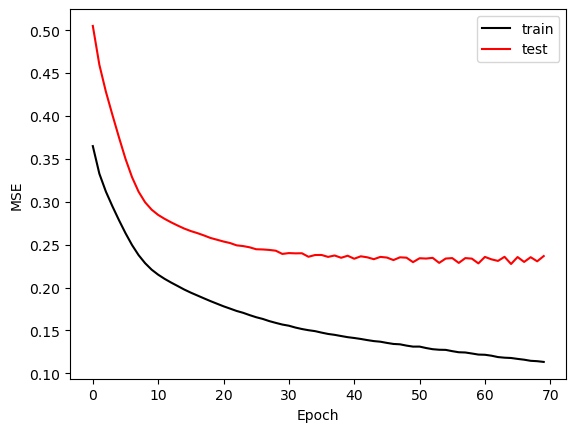

In [99]:
train_loss = jnp.array(metrics_history['train_loss'])
test_loss = jnp.array(metrics_history['test_loss'])

plt.plot(train_loss, color='black', label='train')
plt.plot(test_loss, color='red', label='test')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

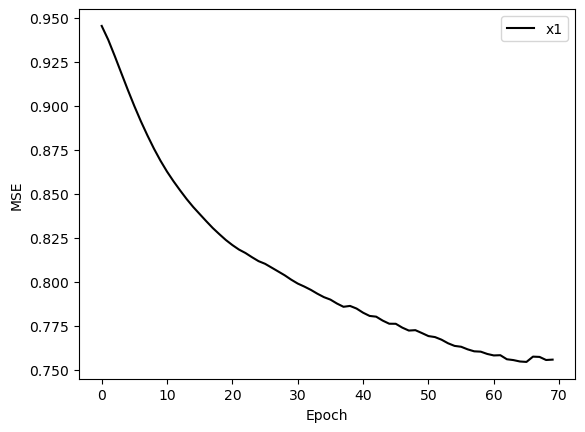

In [100]:
x1 = jnp.array(metrics_history['x1'])

plt.plot(x1, color='black', label='x1')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

In [101]:
def evaluate(module, state=None, params=None, dl=None):

    if params is None:
        if state is None:
            raise("No params provided!")
        params = state.params

    y_mu_np = y_mu.detach().numpy()
    y_sigma_np = y_sigma.detach().numpy()

    # Empty list to store batch-wise tensors
    P = []
    ET = []
    Q = []
    Q_hat = []

    hygr4j.training = False
    hygr4j.s_init = s_init

    for i, (X, y) in enumerate(dl, start=1):

        X = X.detach().numpy()
        y = y.detach().numpy()
        
        y_hat, s_store = module.apply({'params': params}, X, y)
        hygr4j.s_init = s_store/(params['_prod_store']['x1']*hygr4j.scale)

        P.append(X[window_size+1:, 0])
        ET.append(X[window_size+1:, 1])

        Q.append((y[window_size+1:]*y_sigma_np+y_mu_np))
        Q_hat.append((y_hat*y_sigma_np+y_mu_np))

    Q = np.concatenate(Q, axis=0)
    P = np.concatenate(P, axis=0)
    ET = np.concatenate(ET, axis=0)
    Q_hat = jnp.clip(np.concatenate(Q_hat, axis=0), 0)

    nse_score = nse(Q, Q_hat)

    fig, ax = plt.subplots(figsize=(16, 6))

    ax.plot(P, 'g--', label='precip', alpha=0.40)
    ax.plot(ET, 'y--', label='etp', alpha=0.30)
    ax.plot(Q, color='black', label='obs', alpha=1.0)
    ax.plot(Q_hat, color='red', label='pred', alpha=0.75)

    ax.set_xlabel('Timestep')
    ax.set_ylabel('Flow (mm/day)')

    ax.annotate(f'NSE: {nse_score:.4f}',
            xy=(0.8, 0.88), xycoords='figure fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=12)
    ax.set_title('Streamflow prediction')

    plt.legend()


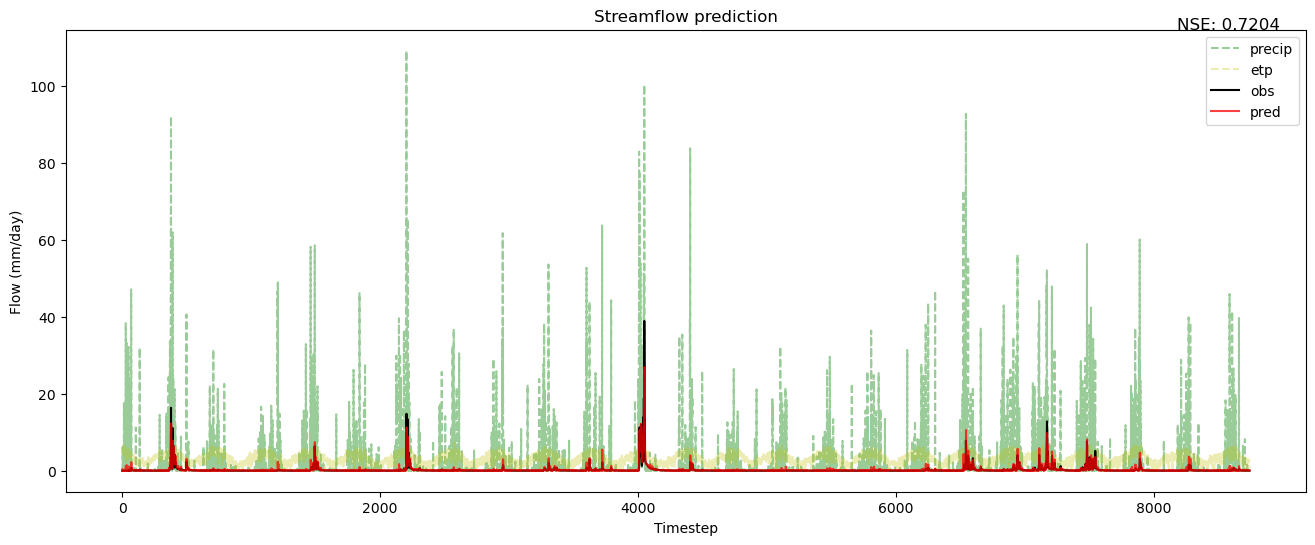

In [102]:
evaluate(module=hygr4j, state=state, dl=train_dl)

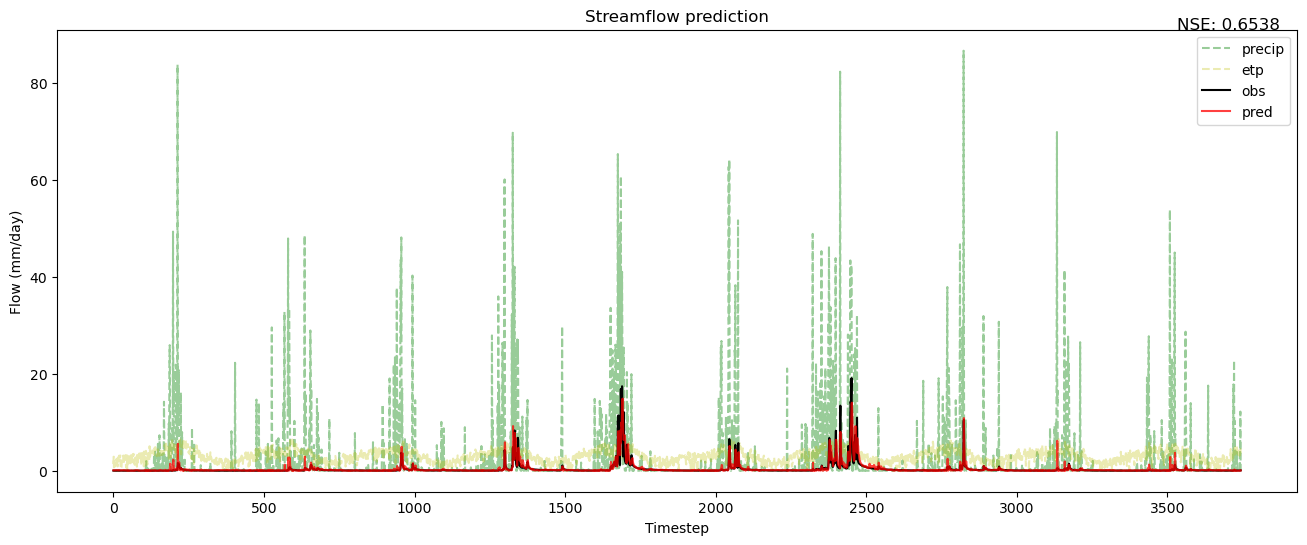

In [103]:
evaluate(module=hygr4j, state=state, dl=test_dl)

In [104]:
state.params['_prod_store']

FrozenDict({
    x1: DeviceArray([0.755947], dtype=float32),
})